# 2. SHO Fitting in Pytorch


In [1]:
import sys

sys.path.append("../../")
sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.nn.Regularization.Regularizers import NegValLoss
# from m3_learning.be.nn import SHO_Model, SHO_NN_Model, SHO_fit_func_nn

# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './../../../Figures/2023_rapid_fitting/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

# import matplotlib.pyplot as plt
# import numpy as np

# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader

# from scipy.signal import resample
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
# from sklearn.metrics import mean_squared_error

from m3_learning.optimizers.AdaHessian import AdaHessian
# from m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
# from m3_learning.be.processing import convert_amp_phase, SHO_fit_to_array
# from m3_learning.util.preprocessing import global_scaler
# from m3_learning.nn.random import random_seed
# from m3_learning.nn.benchmarks.inference import computeTime
from m3_learning.util.file_IO import make_folder
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
# from m3_learning.be.dataset import BE_Dataset
# from m3_learning.viz.style import set_style

# set_style("printing")

2023-05-12 20:07:04.865427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 20:07:04.983973: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-12 20:07:05.433425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-12 20:07:05.433475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loads Data


In [3]:
# Specify the filename and the path to save the file
filename = "data_raw_SHO.h5"
save_path = "./../../../Data/2023_rapid_fitting"


data_path = save_path + "/" + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path, resample_bins=None, SHO_fit_func_NN=SHO_fit_func_nn)

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ Noisy_Data_1_SHO_Fit
  --------------------
  ├ No

## Testing the Torch Function

The function for a simple-harmonic oscillator needs to be recast in PyTorch. Here we prove that the PyTorch function is implemented identically to the Numpy model.

Note: This uses the results from the least squares fitting LSQF results.


In [4]:
BE_viz = Viz(dataset, printing, verbose=True)

In [5]:
dataset.extraction_state


    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = None
    NN Phase Shift = None
    Noise Level = 0
                  


In [55]:
true = {"resampled": False,
        "label": "Raw",
        "noise": 0, 
        "measurement_state": "all"}

predicted = {"fitter": "LSQF", "resampled": False, "label": "Raw", "scaled": False, "noise" : 0}

BE_viz.fit_tester(true, predicted, filename="Figure_7_PyTorch_fit_tester")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './../../../Data/2023_rapid_fitting/data_raw_SHO.h5', errno = 2, error message = 'No such file or directory', flags = 1, o_flags = 2)

**Figure 7** Shows the result of the PyTorch function. The result based on the LSQF results shows that the PyTorch function is implemented correctly.


## Pytorch Model

### Model Architecture


### Scaling the Data

When training the neural network it is useful to scale the data. We apply a global scaler such that the spectrum have a mean of 0 and a standard deviation of 1.

#### Visualizing the Scaled Data



    Dataset = Raw_Data
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = None
    NN Phase Shift = None
    Noise Level = 0
                  
./../../../Figures/2023_rapid_fitting/Figure_8_Scaled Raw Data.png
./../../../Figures/2023_rapid_fitting/Figure_8_Scaled Raw Data.svg


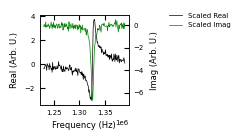

In [7]:
BE_viz = Viz(dataset, printing, verbose=True)

state = {"fitter": "LSQF", "resampled": True, "scaled": True, "label": "Scaled"}

BE_viz.nn_checker(state, filename="Figure_8_Scaled Raw Data")

**Figure 8** shows the scaled data. The data is scaled to have a mean of 0 and a standard deviation of 1. This is done using a global scaler of the entire spectrum.



    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 0
                  
./../../../Figures/2023_rapid_fitting/Figure_9_Phase_Shifted_Scaled_Histograms.png
./../../../Figures/2023_rapid_fitting/Figure_9_Phase_Shifted_Scaled_Histograms.svg


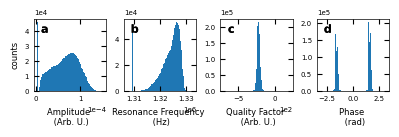

In [8]:
dataset.LSQF_phase_shift = np.pi / 2

BE_viz.SHO_hist(
    dataset.SHO_fit_results(), filename="Figure_9_Phase_Shifted_Scaled_Histograms"
)

**Figure 9** shows the histograms of the scaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is a transformation applied to the phase.


### Training the Model

We will train the model from scratch. Generally the model trains very well in a few epochs. This will take less than 5 minutes to train on a GPU.


In [9]:
random_seed(seed=42)

# instantiate the model
model = SHO_Model(dataset, training=True, model_basename="SHO_Fitter_original_data")

# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle=True)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Using GPU NVIDIA GeForce RTX 3090

    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 0
                  
None


In [10]:
train = True

if train:
    # fits the model
    model.fit(
        dataset.X_train,
        500,
        optimizer="Adam",
        epochs = 5,
    )
else:
    model.load(
        "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0449272525189978.pth"
    )

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch : 1/5, recon loss = 0.06376698
--- 29.454604864120483 seconds ---
epoch : 2/5, recon loss = 0.03506150
--- 28.444324254989624 seconds ---
epoch : 3/5, recon loss = 0.03453432
--- 28.715874195098877 seconds ---
epoch : 4/5, recon loss = 0.03433227
--- 28.98812985420227 seconds ---
epoch : 5/5, recon loss = 0.03419933
--- 28.817856550216675 seconds ---


### Evaluate the Neural Network Results

It is always recommended to validate that the autoencoder is working correctly. We can do this by comparing the different stages of the autoencoder including the raw data, the generated curves.


./../../../Figures/2023_rapid_fitting/Figure_10_NN_validation_Train.png
./../../../Figures/2023_rapid_fitting/Figure_10_NN_validation_Train.svg


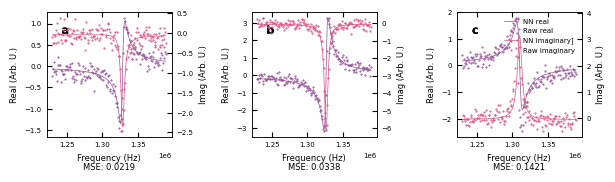

In [12]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_10_NN_validation_Train",
)

**Figure 10** Raw data and reconstruction of the autoendcoder for the training data. Shows the a) best, b) median, and c) worst reconstruction of the training data.


./../../../Figures/2023_rapid_fitting/Figure_11_NN_validation_test.png
./../../../Figures/2023_rapid_fitting/Figure_11_NN_validation_test.svg


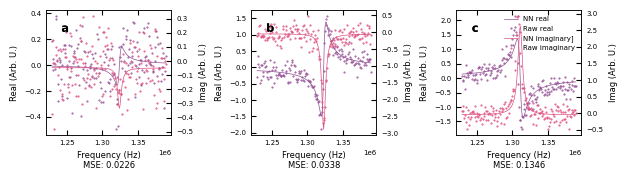

In [13]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    out_state={"scaled": True, "measurement State": "complex"},
    returns=True,
    filename="Figure_11_NN_validation_test",
)

**Figure 11** Raw data and reconstruction of the autoendcoder for the test data. Shows the a) best, b) median, and c) worst reconstruction of the test data.



    Dataset = Raw_Data
    Resample = False
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = False
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = 0
    Noise Level = 0
                  
None
./../../../Figures/2023_rapid_fitting/Figure_12_NN_validation_full_data.png
./../../../Figures/2023_rapid_fitting/Figure_12_NN_validation_full_data.svg


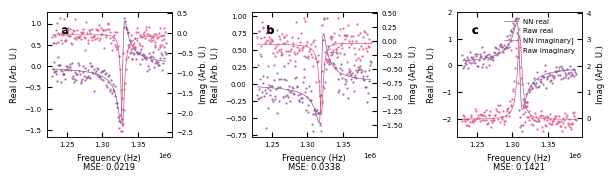

In [14]:
state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
}

X_data, Y_data = dataset.NN_data()

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    state,
    prediction=model,
    out_state={"scaled": True, "measurement State": "complex"},
    returns=True,
    filename="Figure_12_NN_validation_full_data",
)

**Figure 12** Raw data and reconstruction of the autoendcoder for the entire data. Shows the a) best, b) median, and c) worst reconstruction of the entire data.


### Calculate the MSE error

We can calculate the MSE error for the training, test, and entire data set.


In [15]:
dataset.get_state

{'resampled': False,
 'raw_format': 'complex',
 'fitter': 'LSQF',
 'scaled': True,
 'output_shape': 'pixels',
 'measurement_state': 'all',
 'resampled_bins': 165,
 'LSQF_phase_shift': 1.5707963267948966,
 'NN_phase_shift': 0,
 'noise': 0}

In [17]:
dataset.get_state

{'resampled': True,
 'raw_format': 'complex',
 'fitter': 'LSQF',
 'scaled': True,
 'output_shape': 'index',
 'measurement_state': 'all',
 'resampled_bins': 165,
 'LSQF_phase_shift': 1.5707963267948966,
 'NN_phase_shift': None,
 'noise': 0}

In [43]:
param = dataset.SHO_LSQF_data['Raw_Data-SHO_Fit_000'].reshape(-1,4)

array([1229492.2, 1230468.8, 1231445.2, 1232421.9, 1233398.5, 1234375. ,
       1235351.5, 1236328.1, 1237304.8, 1238281.2, 1239257.8, 1240234.4,
       1241211. , 1242187.5, 1243164. , 1244140.6, 1245117.2, 1246093.8,
       1247070.2, 1248046.9, 1249023.5, 1250000. , 1250976.5, 1251953.1,
       1252929.8, 1253906.2, 1254882.8, 1255859.4, 1256836. , 1257812.5,
       1258789. , 1259765.6, 1260742.2, 1261718.8, 1262695.2, 1263671.9,
       1264648.5, 1265625. , 1266601.5, 1267578.1, 1268554.8, 1269531.2,
       1270507.8, 1271484.4, 1272461. , 1273437.5, 1274414. , 1275390.6,
       1276367.2, 1277343.8, 1278320.2, 1279296.9, 1280273.5, 1281250. ,
       1282226.5, 1283203.1, 1284179.8, 1285156.2, 1286132.8, 1287109.4,
       1288086. , 1289062.5, 1290039. , 1291015.6, 1291992.2, 1292968.8,
       1293945.2, 1294921.9, 1295898.5, 1296875. , 1297851.5, 1298828.1,
       1299804.8, 1300781.2, 1301757.8, 1302734.4, 1303711. , 1304687.5,
       1305664. , 1306640.6, 1307617.2, 1308593.8, 

In [51]:
# fix this to make it more simple, only going to use one fitting function
SHO_fit_func_nn(torch.from_numpy(param),dataset.get_freq_values(165)).shape

torch.Size([1382400, 165])

In [98]:
dataset.get_state

dataset.set_attributes(**dataset.get_state)

In [94]:
dataset.scaled = True

pred_data_ = dataset.raw_spectra(
        fit_results=parms)

In [35]:

pred_data, parms = dataset.get_raw_data_from_LSQF_SHO(LSQF_)

In [33]:
x, y = dataset.NN_data()


    Dataset = Raw_Data
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 0
                  
None


In [47]:
Y_data.shape

torch.Size([1382400, 4])

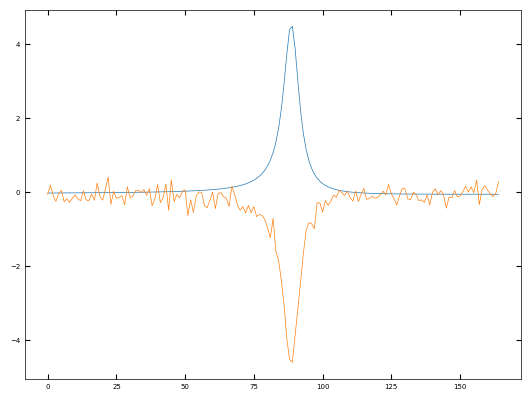

In [37]:
import matplotlib.pyplot as plt
import torch
import torch.nn

plt.plot(torch.from_numpy(pred_data)[100, :, 1])
plt.plot(x[100, :, 1])
# plt.plot(x[100, :, 1],'k')

In [30]:
a = np.zeros((1, 1, 1))


True

In [31]:
X_data, Y_data = dataset.NN_data()
LSQF_ = {'resampled': True,
                'raw_format': 'complex',
                'fitter': 'LSQF',
                'scaled': True,
                'output_shape': 'index',
                'measurement_state': 'all',
                'resampled_bins': 165,
                'LSQF_phase_shift': 1.5707963267948966,
                'NN_phase_shift': None,
                'noise': 0}

data = (LSQF_, X_data, X_test, X_train)
labels = ["LSQF", "Full Data", "Test Data", "Train Data"]

model.print_mse(data, labels)


    Dataset = Raw_Data
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 0
    NN Phase Shift = None
    Noise Level = 0
                  
None

    Dataset = Raw_Data
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 0
    NN Phase Shift = None
    Noise Level = 0
                  
None
LSQF Mean Squared Error: 0.0345
Full Data Mean Squared Error: 0.0340
Test Data Mean Squared Error: 0.0340
Train Data Mean Squared Error: 0.0341


From here on out we will assume that the autoencoder is working correctly, and is not overfit. This is a good assumption because the results are more or less the same for the training, test, and entire data set.

We note that the LSQF has a somewhat lower MSE, this does not necessarily mean that it is doing a better job fitting. 
1. The quality of the MSE is not an indicator of how good the parameters are fit, just an indicator of how good the reconstruction is.
2. There could be some aliasing in the LSQF results, which would result in a lower MSE.


### GPU Inference Speedtest

Here we show the speedtest for the GPU. This is done using the torch.cuda.synchronize() function. This is used to ensure that the GPU is done processing before the timer is stopped.


In [18]:
X_data, Y_data = dataset.NN_data()

model.inference_timer(X_data, batch_size=1000)

Mean execution time computed for 1383 batches of size 1000
Average execution time per batch (ms): 2.466728 ± 0.308991
Average execution time per iteration (ms): 0.002467 ± 0.000309
Total execution time (s): 3.41 


### Histogram of Fit Results

It is useful to view the histogram of the fitting results to apply any necessary phase shifts, and to see if the results are reasonable.



                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = index
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = 1.5707963267948966
                  
./../../../Figures/2023_rapid_fitting/Figure_13_NN_Unscaled_Parameters_Histograms.png
./../../../Figures/2023_rapid_fitting/Figure_13_NN_Unscaled_Parameters_Histograms.svg


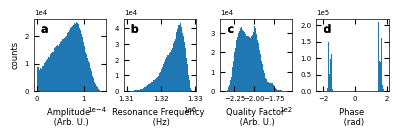

In [19]:
# we will add the appropriate phase shift to the dataset based on the fix seed,
# If your seed is different the results might vary
dataset.NN_phase_shift = np.pi/2 

# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = model.predict(X_data)

BE_viz.SHO_hist(parm, filename="Figure_13_NN_Unscaled_Parameters_Histograms")

**Figure 13** Histogram of the fit results for the a) amplitude, b) resonance frequency, c) quality factor, and d) phase.



                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = index
                  Measurement State = all
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = 1.5707963267948966
                  
./../../../Figures/2023_rapid_fitting/Figure_13_NN_scaled_Parameters_Histograms.png
./../../../Figures/2023_rapid_fitting/Figure_13_NN_scaled_Parameters_Histograms.svg


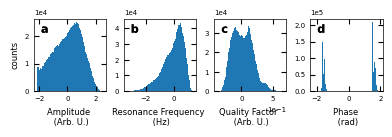

In [20]:
out = dataset.SHO_scaler.transform(parm)

BE_viz.SHO_hist(out, filename="Figure_13_NN_scaled_Parameters_Histograms")

**Figure 14** Histogram of the fit results for the a) amplitude, b) resonance frequency, c) quality factor, and d) phase. The histograms show the scaled parameters.


./../../../Figures/2023_rapid_fitting/Figure_15_NN_Switching_Maps.png
./../../../Figures/2023_rapid_fitting/Figure_15_NN_Switching_Maps.svg


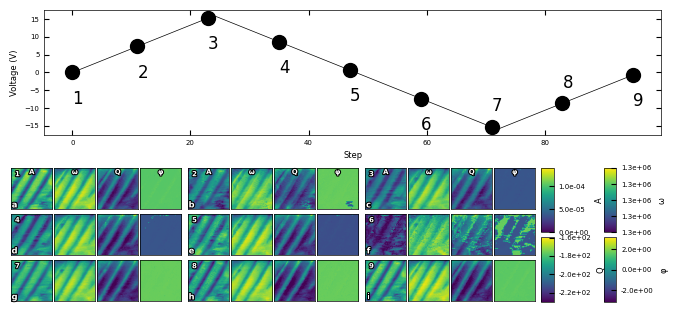

In [67]:
# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = model.predict(X_data)

BE_viz.SHO_switching_maps(parm, filename="Figure_15_NN_Switching_Maps")

## Comparison SHO and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.


(1382400, 80) (1382400, 80) (1382400, 4)


/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/dataset.py:660: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(fit_results.reshape(-1, 4))


(1382400, 80) (1382400, 80) torch.Size([1382400, 4])
1183222
104603
15421
1368115
164988
21130
./../../../Figures/2023_rapid_fitting/Figure_14_LSQF_NN_bmw_comparison.png
./../../../Figures/2023_rapid_fitting/Figure_14_LSQF_NN_bmw_comparison.svg


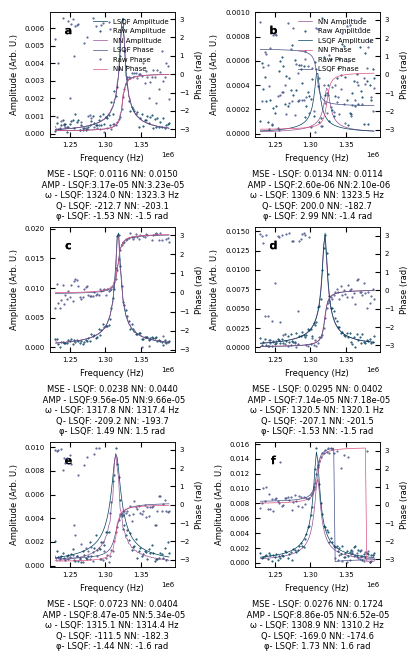

In [128]:
dataset.NN_phase_shift = np.pi/2
dataset.LSQF_phase_shift = np.pi/2

true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
}

out_state = {"scaled": True, "raw_format": "magnitude spectrum"}

n = 1

LSQF = BE_viz.get_best_median_worst(
    true_state,
    prediction={"fitter": "LSQF"},
    out_state=out_state,
    SHO_results=True,
    n=n,
)

NN = BE_viz.get_best_median_worst(
    true_state, prediction=model, out_state=out_state, SHO_results=True, n=n
)

data = (LSQF, NN)
names = ["LSQF", "NN"]

BE_viz.SHO_Fit_comparison(
    data,
    names,
    model_comparison=[model, {"fitter": "LSQF"}],
    out_state=out_state,
    filename="Figure_14_LSQF_NN_bmw_comparison",
    # display_results = None
)

### Statistics of the Results for Training, Validation, and Entire Dataset


In [70]:
dataset.extraction_state


                  Resample = True
                  Raw Format = complex
                  fitter = LSQF
                  scaled = True
                  Output Shape = index
                  Measurement State = off
                  Resample Resampled = True
                  Resample Bins = 80
                  LSQF Phase Shift = 1.5707963267948966
                  NN Phase Shift = 1.5707963267948966
                  


<AxesSubplot: xlabel='parameter', ylabel='value'>

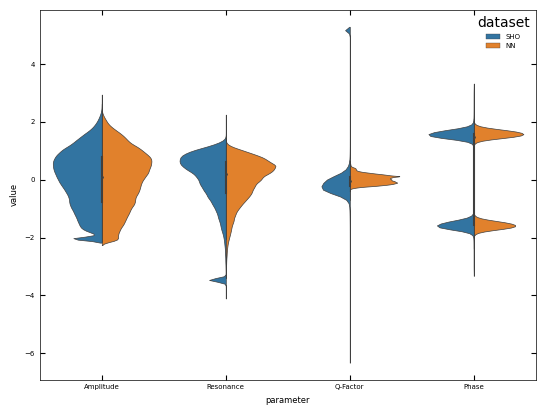

In [75]:
import pandas as pd

state = {
    "fitter": "LSQF",
    "resampled": True,
    "scaled": True,
    "raw_format": "complex",
    "measurement_state": "all"
}

BE_viz.set_attributes(**state)

df = pd.DataFrame()

# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = model.predict(X_data)

scaled_param = dataset.SHO_scaler.transform(parm)

true = dataset.SHO_fit_results().reshape(-1, 4) 
compare = scaled_param

true_df = pd.DataFrame(true, columns=["Amplitude", "Resonance", "Q-Factor", "Phase"])
predicted_df = pd.DataFrame(
    compare, columns=["Amplitude", "Resonance", "Q-Factor", "Phase"]
)

df = pd.concat((true_df, predicted_df))


names = [true, compare]
names_str = ["SHO", "NN"]
labels = ["Amplitude", "Resonance", "Q-Factor", "Phase"]

for j, name in enumerate(names):
    for i, label in enumerate(labels):
        dict_ = {
            "value": name[:, i],
            "parameter": np.repeat(label, name.shape[0]),
            "dataset": np.repeat(names_str[j], name.shape[0]),
        }

        df = pd.concat((df, pd.DataFrame(dict_)))
        
sns.violinplot(data=df, x="parameter", y="value", hue="dataset", split=True)

In [83]:
true_.shape

(46873, 1, 4)

(46873, 80) (46873, 80) (1382400, 4)


/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/dataset.py:660: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(fit_results.reshape(-1, 4))


(46873, 80) (46873, 80) torch.Size([1382400, 4])
./../../../Figures/2023_rapid_fitting/Figure_14_LSQF_NN_bmw_comparison.png
./../../../Figures/2023_rapid_fitting/Figure_14_LSQF_NN_bmw_comparison.svg


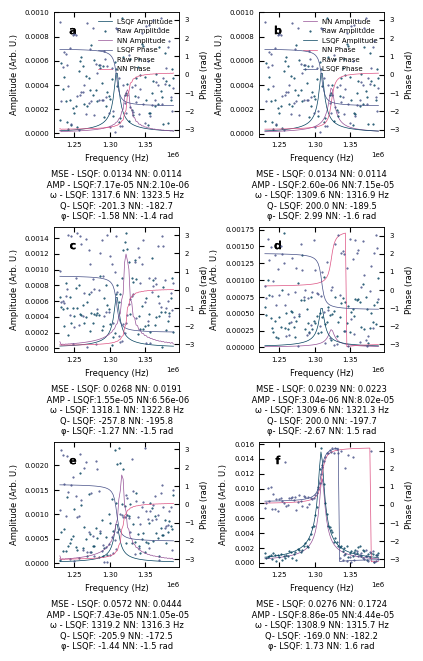

In [130]:
# finds the index less than a certain value
# we can add something a function to generalize this TODO
ind = np.argwhere(true[:,1]< -3).flatten()

dataset.NN_phase_shift = np.pi/2
dataset.LSQF_phase_shift = np.pi/2

true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all"
}

out_state = {"scaled": True, "raw_format": "magnitude spectrum"}

n = 1

LSQF = BE_viz.get_best_median_worst(
    true_state,
    prediction={"fitter": "LSQF"},
    out_state=out_state,
    SHO_results=True,
    n=n,
    index = ind,
)

NN = BE_viz.get_best_median_worst(
    true_state, prediction=model,
    out_state=out_state, SHO_results=True, n=n, index = ind
)

data = (LSQF, NN)
names = ["LSQF", "NN"]

BE_viz.SHO_Fit_comparison(
    data,
    names,
    model_comparison=[model, {"fitter": "LSQF"}],
    out_state=out_state,
    filename="Figure_14_LSQF_NN_bmw_comparison",
    # display_results = None
)

In [114]:
#unpack the data
d1, d2, x1, x2, label, index1, mse1, params = data[0]

In [125]:
x2.shape

(80,)

In [123]:
 d2[0].squeeze()[0].flatten().shape

(80,)

In [106]:
d2.shape
x2.shape
d2.shape
x2.shape

(80,)

In [108]:
print(d1.shape, d2.shape, x1.shape, x2.shape)

(3, 2, 80) (3, 2, 80) (80,) (80,)


In [81]:


true_ = true[ind]
compare_ = compare[ind]

out_state = {"scaled": True, "raw_format": "magnitude spectrum"}

n = 1

LSQF = BE_viz.get_best_median_worst(
    true_,
    prediction=compare_,
    out_state=out_state,
    SHO_results=True,
    n=n,
)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
# state = {
#     "fitter": "LSQF",
#     "resampled": True,
#     "scaled": True,
#     "raw_format": "complex",
#     "measurement_state": "all"
# }

# BE_viz.set_attributes(**state)


# true = scaled_param
# compare = dataset.SHO_fit_results().reshape(-1, 4)

# # build a dictionary:
# DataNames = [true, compare]
# labels = ["Amplitude", "Resonance", "Q-Factor", "Phase"]
# names_str = ["NN", "SHO"]

# df = pd.DataFrame()

# for i, data in enumerate(DataNames):
#     for j, signal in enumerate(labels):
#         dict_ = {
#             "value": data[:, j],
#             "parameter": np.repeat(signal, data.shape[0]),
#             "dataset": np.repeat(names_str[i], data.shape[0]),
#         }

#         df = pd.concat((df, pd.DataFrame(dict_)))

<AxesSubplot: xlabel='parameter', ylabel='value'>

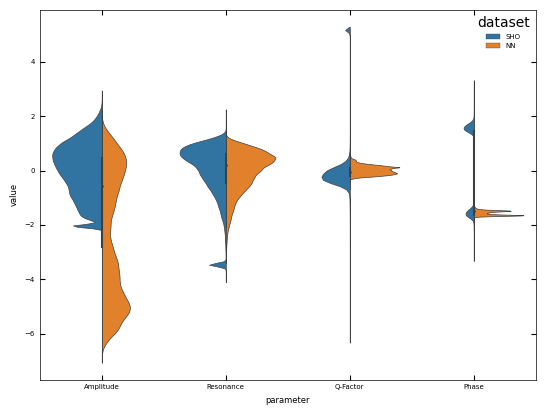

In [73]:
import seaborn as sns



In [ ]:
import seaborn as sns
import pandas as pd

# Create a random dataset with two categories
data = pd.DataFrame(
    {
        "category": ["left"] * 100 + ["right"] * 100,
        "value": np.concatenate([np.random.randn(100), np.random.randn(100) + 2]),
    }
)

# Create a violin plot with left and right categories
sns.violinplot(x="category", y="value", hue="category", data=data, split=True)

In [ ]:
df.head()

In [ ]:
df.head()

## Comparison of NN and LSQF Results

It is useful to compare the NN and LSQF results. While generally, the LSQF results might be considered the ground truth, this is not really the case. It is unclear which fitting method is actually more precise and accurate. We conjecture through this analysis that the neural network is actually a more accurate and precise fitting method.

This section will help to make this case.


In [ ]:
state = {
    "fitter": "LSQF",
    "resampled": True,
    "scaled": False,
    "raw_format": "magnitude spectrum",
}

BE_viz.set_attributes(**state)

LSQF_results = dataset.raw_spectra(fit_results=dataset.SHO_fit_results())

state = {
    "fitter": "LSQF",
    "resampled": True,
    "scaled": False,
    "raw_format": "magnitude spectrum",
}

BE_viz.set_attributes(**state)

raw_spectra = dataset.raw_spectra()

# ind, mse = BE_viz.best_median_worst_fit_comparison(LSQF_results, raw_spectra, 1, 1)

In [ ]:
BE_viz.best_median_worst_fit_comparison()

In [ ]:
self = BE_viz

# for the SHO curves it makes sense to determine the error based on the normalized fit results in complex form.
state = {
    "fitter": "LSQF",
    "resampled": False,
    "scaled": True,
    "raw_format": "complex",
}

self.set_attributes(**state)

fit_results_compare = self.dataset.raw_spectra(
    fit_results=self.dataset.SHO_fit_results()
)

raw_SHO = self.dataset.raw_spectra()

index1, mse1, d1, d2 = SHO_Model.get_rankings(raw_SHO, fit_results_compare, n=1)

In [ ]:
index1

In [ ]:
a = raw_SHO[0].reshape(-1, 165)[745386]
b = np.array(fit_results_compare[0].reshape(-1, 165)[745386])

a1 = raw_SHO[1].reshape(-1, 165)[745386]
b1 = np.array(fit_results_compare[1].reshape(-1, 165)[745386])

In [ ]:
(np.mean((a - b) ** 2) + np.mean((a1 - b1) ** 2)) / 2

In [ ]:
X_data.shape

In [ ]:
dataset.resampled_freq.shape

In [ ]:
plt.plot(dataset.frequency_bin)
plt.plot(dataset.resampled_freq, "o")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_data[745386, :, 0])
# plt.plot(dataset.frequency_bin, a)
# plt.plot(dataset.frequency_bin, b)

In [ ]:
state = {
    "fitter": "LSQF",
    "resampled": True,
    "scaled": True,
    "raw_format": "complex",
}

BE_viz.set_attributes(**state)

LSQF_results = dataset.raw_spectra(fit_results=dataset.SHO_fit_results())

In [ ]:
np.array(d1).shape

In [ ]:
d1[1][0].shape

In [ ]:
plt.plot(d1[0][0])
plt.plot(d1[1][0])
mse1[0]

In [ ]:
np.array(LSQF_results).shape.index(2)

In [ ]:
np.array(LSQF_results).shape.index(2)

In [ ]:
index, mse, c1, c2 = SHO_Model.get_rankings(LSQF_results, raw_spectra, n=1, curves=True)

In [ ]:
c1.shape

In [ ]:
plt.plot(c1[0, 0])
plt.plot(c2[0, 0], "o")

In [ ]:
plt.plot(c1[2, :, 1])
plt.plot(c2[2, :, 1], "o")

In [ ]:
[tensor.numpy() for tensor in LSQF_results]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(LSQF_results[0][100, 100, :])
plt.plot(raw_spectra[0][100, 100, :])

In [ ]:
[0### LSQF NN compairison resonstruction

### LSQF NN comapairison distributions

### LSQF NN comparison movies.'

In [54]:
number_to_letters(28)

'ac'